In [1]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception, EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import torch

2025-08-05 19:50:12.608953: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 19:50:13.067933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 19:50:14.296452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_FRAMES = 100  # Number of frames per video to process
FRAME_SAMPLE_RATE = 2  # Process every 2th frame to reduce computation


In [3]:
def load_h5_data_with_labels(real_path, fake_path):
    """
    Load data from HDF5 files with proper labeling
    Args:
        real_path: path to HDF5 file containing original/real videos
        fake_path: path to HDF5 file containing deepfake videos
    Returns:
        X: numpy array of images (n_samples, 224, 224, 3)
        y: numpy array of labels (0=real, 1=fake)
    """
    real_data = []
    fake_data = []
    
    # Load real videos (label 0)
    with h5py.File(real_path, 'r') as f_real:
        for video_name in f_real.keys():
            frames = f_real[video_name][:]  # shape: (100, 224, 224, 3)
            # Sample frames at specified rate
            sampled_frames = frames[::FRAME_SAMPLE_RATE]
            real_data.extend(sampled_frames)
    
    # Load fake videos (label 1)
    with h5py.File(fake_path, 'r') as f_fake:
        for video_name in f_fake.keys():
            frames = f_fake[video_name][:]  # shape: (100, 224, 224, 3)
            # Sample frames at specified rate
            sampled_frames = frames[::FRAME_SAMPLE_RATE]
            fake_data.extend(sampled_frames)
    
    # Create labels
    real_labels = np.zeros(len(real_data), dtype=np.int32)  # 0 for real
    fake_labels = np.ones(len(fake_data), dtype=np.int32)   # 1 for fake
    
    # Combine data
    X = np.concatenate([real_data, fake_data])
    y = np.concatenate([real_labels, fake_labels])
    
    return X, y

Total samples: 14000
Real samples: 7000
Fake samples: 7000
Sample shape: (224, 224, 3)


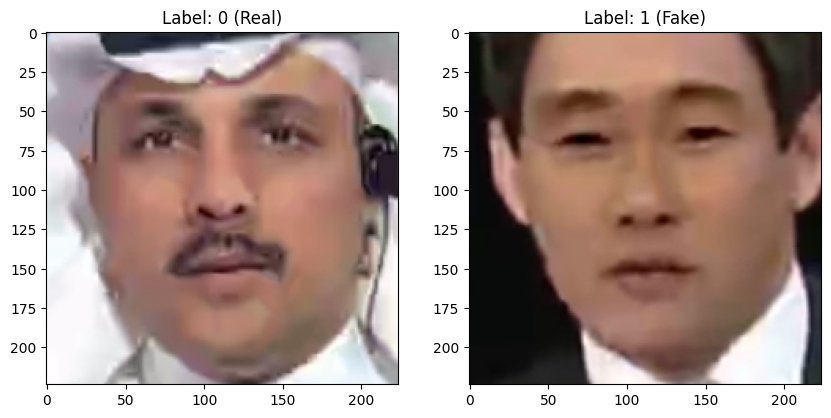

In [4]:
# Load and verify data
X, y = load_h5_data_with_labels('FF++_original_c40_test_only.h5', 'FF++_Deepfakes_c40_test_only.h5')

# Check shapes and labels
print(f"Total samples: {len(X)}")
print(f"Real samples: {sum(y == 0)}")
print(f"Fake samples: {sum(y == 1)}")
print(f"Sample shape: {X[0].shape}")

# Visualize samples
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[0]/255.)  # First real sample
plt.title(f"Label: {y[0]} (Real)")
plt.subplot(1, 2, 2)
plt.imshow(X[-1]/255.)  # Last fake sample
plt.title(f"Label: {y[-1]} (Fake)")
plt.show()

In [5]:
# Normalize pixel values
X = X.astype('float32') / 255.0

# Split data - maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain same class ratio in splits
)

In [ ]:
# Data augmentation designed to improve generalization while preserving manipulation artifacts:

train_datagen = ImageDataGenerator(

# '''
# - Small rotations/shifts account for camera/human pose variations
# - Limited zoom/shear maintains facial feature relationships
# - Horizontal flip preserves symmetric facial features but may hide asymmetric artifacts
# fill_mode='nearest'  # Preferred over 'constant', 'reflect', or 'wrap' because:
# - Maintains sharp boundaries where artifacts often appear
# - Avoids introducing interpolation artifacts that could obscure real fake clues
# - Preserves high-frequency components important for detection
# '''
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE
)

In [ ]:
# Detection Model version 1

# from tensorflow.keras.models import Model  # Import Model class
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# def create_improved_xception_model():
#     base_model = Xception(
#         weights=None,  # We're using our local weights
#         include_top=False,
#         input_shape=(224, 224, 3),
#         pooling='avg'  # Add global pooling directly
#     )
    
#     # Load local weights
#     base_model.load_weights('xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
#     # Freeze first N layers (experiment with this number)
#     for layer in base_model.layers[:20]:
#         layer.trainable = False
    
#     # Enhanced classifier head
#     x = layers.Dense(1024, activation='relu')(base_model.output)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.6)(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.4)(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
    
#     model = Model(inputs=base_model.input, outputs=outputs)
    
#     model.compile(
#         optimizer=Adam(learning_rate=1e-5, clipnorm=1.0),
#         loss='binary_crossentropy',
#         metrics=['accuracy', tf.keras.metrics.AUC()]
#     )
#     return model

In [ ]:
# # Model improvement
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

def create_improved_xception(input_shape=(224, 224, 3), num_classes=1):
    # Load base model with adjusted parameters
    base_model = Xception(
        weights=None,  # We're using our local weights
        include_top=False,
        input_shape=input_shape,
        pooling=None,
        classifier_activation=None
        )
    
    # Load local weights
    base_model.load_weights('xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    # Fine-tune more layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Enhanced artifact detection branch
    artifact_branch = layers.Conv2D(256, (3,3), activation='relu', padding='same')(base_model.output)
    artifact_branch = layers.BatchNormalization()(artifact_branch)
    artifact_branch = layers.Conv2D(128, (3,3), activation='relu', padding='same')(artifact_branch)
    artifact_branch = layers.MaxPooling2D((2,2))(artifact_branch)
    
    # Spatial attention mechanism
    attention = layers.Conv2D(1, (1,1), activation='sigmoid')(artifact_branch)
    # artifact_branch = layers.multiply([artifact_branch, attention])
    
    artifact_branch = layers.GlobalAveragePooling2D()(artifact_branch)
    
    # Main feature processing
    main_branch = layers.GlobalAveragePooling2D()(base_model.output)
    
    # Merge with additional feature processing
    merged = layers.Concatenate()([main_branch, artifact_branch])
    merged = layers.Dense(512, activation='relu')(merged)
    merged = layers.Dropout(0.7)(merged)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='sigmoid')(merged)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    # Custom optimizer configuration
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=5e-6,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

In [ ]:
# Create and train model
print("Creating model...")
model = create_improved_xception()

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training model...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS, # best epoch
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stop]
)

Creating model...


2025-08-05 19:52:37.942896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 19:52:37.956506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 19:52:37.960212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Training model...


/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1754394771.849873    2249 service.cc:145] XLA service 0x7f9644004d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754394771.849904    2249 service.cc:153]   StreamExecutor device (0): NVIDIA A10, Compute Capability 8.6
2025-08-05 19:52:52.045632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-05 19:52:53.049036: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


  2/350 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.3906 - loss: 0.7699 - precision: 0.3573 - recall: 0.5239   

I0000 00:00:1754394783.415842    2249 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5204 - loss: 0.7089 - precision: 0.5241 - recall: 0.5989

350/350 ━━━━━━━━━━━━━━━━━━━━ 107s 242ms/step - accuracy: 0.5205 - loss: 0.7089 - precision: 0.5241 - recall: 0.5988 - val_accuracy: 0.6396 - val_loss: 0.6412 - val_precision: 0.6246 - val_recall: 0.7000
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6347 - loss: 0.6353 - precision: 0.6451 - recall: 0.5783

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.6348 - loss: 0.6353 - precision: 0.6452 - recall: 0.5784 - val_accuracy: 0.7279 - val_loss: 0.5441 - val_precision: 0.7424 - val_recall: 0.6979
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7259 - loss: 0.5401 - precision: 0.7364 - recall: 0.7213

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.7260 - loss: 0.5400 - precision: 0.7365 - recall: 0.7213 - val_accuracy: 0.8168 - val_loss: 0.4109 - val_precision: 0.8373 - val_recall: 0.7864
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8104 - loss: 0.4306 - precision: 0.8257 - recall: 0.7870

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.8105 - loss: 0.4305 - precision: 0.8257 - recall: 0.7870 - val_accuracy: 0.8557 - val_loss: 0.3234 - val_precision: 0.9082 - val_recall: 0.7914
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8593 - loss: 0.3346 - precision: 0.8614 - recall: 0.8568

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.8594 - loss: 0.3345 - precision: 0.8614 - recall: 0.8568 - val_accuracy: 0.8979 - val_loss: 0.2426 - val_precision: 0.9169 - val_recall: 0.8750
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8923 - loss: 0.2689 - precision: 0.8958 - recall: 0.8855

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.8923 - loss: 0.2689 - precision: 0.8958 - recall: 0.8855 - val_accuracy: 0.9264 - val_loss: 0.1923 - val_precision: 0.9606 - val_recall: 0.8893
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9194 - loss: 0.2078 - precision: 0.9264 - recall: 0.9111

350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 227ms/step - accuracy: 0.9194 - loss: 0.2078 - precision: 0.9264 - recall: 0.9111 - val_accuracy: 0.9382 - val_loss: 0.1507 - val_precision: 0.9555 - val_recall: 0.9193
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9236 - loss: 0.1895 - precision: 0.9266 - recall: 0.9205

350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.9236 - loss: 0.1895 - precision: 0.9267 - recall: 0.9205 - val_accuracy: 0.9468 - val_loss: 0.1357 - val_precision: 0.9771 - val_recall: 0.9150
Epoch 9/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9418 - loss: 0.1563 - precision: 0.9440 - recall: 0.9378

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9418 - loss: 0.1563 - precision: 0.9440 - recall: 0.9378 - val_accuracy: 0.9514 - val_loss: 0.1237 - val_precision: 0.9781 - val_recall: 0.9236
Epoch 10/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9452 - loss: 0.1434 - precision: 0.9449 - recall: 0.9461

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.9452 - loss: 0.1434 - precision: 0.9449 - recall: 0.9461 - val_accuracy: 0.9525 - val_loss: 0.1263 - val_precision: 0.9899 - val_recall: 0.9143
Epoch 11/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9505 - loss: 0.1286 - precision: 0.9516 - recall: 0.9484

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9505 - loss: 0.1286 - precision: 0.9516 - recall: 0.9484 - val_accuracy: 0.9675 - val_loss: 0.0837 - val_precision: 0.9753 - val_recall: 0.9593
Epoch 12/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9584 - loss: 0.1184 - precision: 0.9595 - recall: 0.9577

350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.9584 - loss: 0.1183 - precision: 0.9595 - recall: 0.9577 - val_accuracy: 0.9711 - val_loss: 0.0735 - val_precision: 0.9782 - val_recall: 0.9636
Epoch 13/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.9647 - loss: 0.0945 - precision: 0.9670 - recall: 0.9625 - val_accuracy: 0.9693 - val_loss: 0.0777 - val_precision: 0.9896 - val_recall: 0.9486
Epoch 14/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.9626 - loss: 0.0947 - precision: 0.9658 - recall: 0.9596 - val_accuracy: 0.9689 - val_loss: 0.0919 - val_precision: 0.9932 - val_recall: 0.9443
Epoch 15/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9684 - loss: 0.0875 - precision: 0.9715 - recall: 0.9657

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9684 - loss: 0.0875 - precision: 0.9715 - recall: 0.9657 - val_accuracy: 0.9764 - val_loss: 0.0689 - val_precision: 0.9926 - val_recall: 0.9600
Epoch 16/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9701 - loss: 0.0736 - precision: 0.9698 - recall: 0.9696

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9701 - loss: 0.0736 - precision: 0.9698 - recall: 0.9696 - val_accuracy: 0.9782 - val_loss: 0.0553 - val_precision: 0.9841 - val_recall: 0.9721
Epoch 17/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9770 - loss: 0.0630 - precision: 0.9788 - recall: 0.9751

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9770 - loss: 0.0631 - precision: 0.9788 - recall: 0.9751 - val_accuracy: 0.9836 - val_loss: 0.0454 - val_precision: 0.9836 - val_recall: 0.9836
Epoch 18/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.9787 - loss: 0.0620 - precision: 0.9807 - recall: 0.9769 - val_accuracy: 0.9821 - val_loss: 0.0513 - val_precision: 0.9898 - val_recall: 0.9743
Epoch 19/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9763 - loss: 0.0686 - precision: 0.9795 - recall: 0.9745 - val_accuracy: 0.9836 - val_loss: 0.0432 - val_precision: 0.9878 - val_recall: 0.9793
Epoch 20/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9827 - loss: 0.0504 - precision: 0.9838 - recall: 0.9818

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9827 - loss: 0.0504 - precision: 0.9838 - recall: 0.9818 - val_accuracy: 0.9846 - val_loss: 0.0373 - val_precision: 0.9843 - val_recall: 0.9850
Epoch 21/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9840 - loss: 0.0451 - precision: 0.9839 - recall: 0.9837

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9840 - loss: 0.0451 - precision: 0.9839 - recall: 0.9837 - val_accuracy: 0.9871 - val_loss: 0.0373 - val_precision: 0.9830 - val_recall: 0.9914
Epoch 22/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9836 - loss: 0.0455 - precision: 0.9834 - recall: 0.9839

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9836 - loss: 0.0455 - precision: 0.9834 - recall: 0.9839 - val_accuracy: 0.9879 - val_loss: 0.0337 - val_precision: 0.9914 - val_recall: 0.9843
Epoch 23/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9858 - loss: 0.0438 - precision: 0.9867 - recall: 0.9854

350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.9858 - loss: 0.0438 - precision: 0.9867 - recall: 0.9854 - val_accuracy: 0.9886 - val_loss: 0.0354 - val_precision: 0.9893 - val_recall: 0.9879
Epoch 24/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.9869 - loss: 0.0399 - precision: 0.9855 - recall: 0.9884 - val_accuracy: 0.9825 - val_loss: 0.0459 - val_precision: 0.9956 - val_recall: 0.9693
Epoch 25/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 221ms/step - accuracy: 0.9868 - loss: 0.0417 - precision: 0.9867 - recall: 0.9870 - val_accuracy: 0.9882 - val_loss: 0.0299 - val_precision: 0.9858 - val_recall: 0.9907
Epoch 26/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9881 - loss: 0.0375 - precision: 0.9899 - recall: 0.9863

350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 225ms/step - accuracy: 0.9881 - loss: 0.0374 - precision: 0.9899 - recall: 0.9863 - val_accuracy: 0.9896 - val_loss: 0.0316 - val_precision: 0.9942 - val_recall: 0.9850
Epoch 27/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9862 - loss: 0.0375 - precision: 0.9873 - recall: 0.9852

350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.9862 - loss: 0.0375 - precision: 0.9873 - recall: 0.9852 - val_accuracy: 0.9936 - val_loss: 0.0252 - val_precision: 0.9936 - val_recall: 0.9936
Epoch 28/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.9879 - loss: 0.0336 - precision: 0.9876 - recall: 0.9881 - val_accuracy: 0.9896 - val_loss: 0.0277 - val_precision: 0.9914 - val_recall: 0.9879
Epoch 29/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9896 - loss: 0.0296 - precision: 0.9903 - recall: 0.9890 - val_accuracy: 0.9904 - val_loss: 0.0279 - val_precision: 0.9935 - val_recall: 0.9871
Epoch 30/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0.9890 - loss: 0.0278 - precision: 0.9890 - recall: 0.9890 - val_accuracy: 0.9929 - val_loss: 0.0224 - val_precision: 0.9901 - val_recall: 0.9957


Evaluating model...
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1400
           1       0.99      1.00      0.99      1400

    accuracy                           0.99      2800
   macro avg       0.99      0.99      0.99      2800
weighted avg       0.99      0.99      0.99      2800

Confusion Matrix:
[[1386   14]
 [   6 1394]]


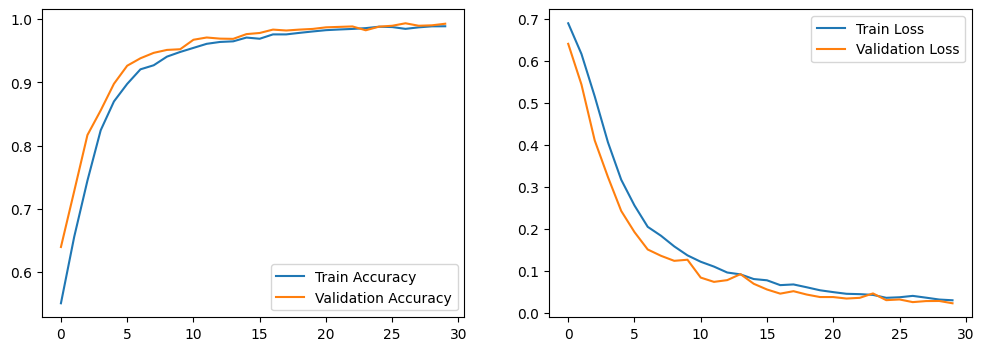

In [12]:
# Evaluate model
print("Evaluating model...")
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Directly load the model if it's trained before

# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('best_model.h5')

# # Verify the model is loaded correctly
# model.summary()

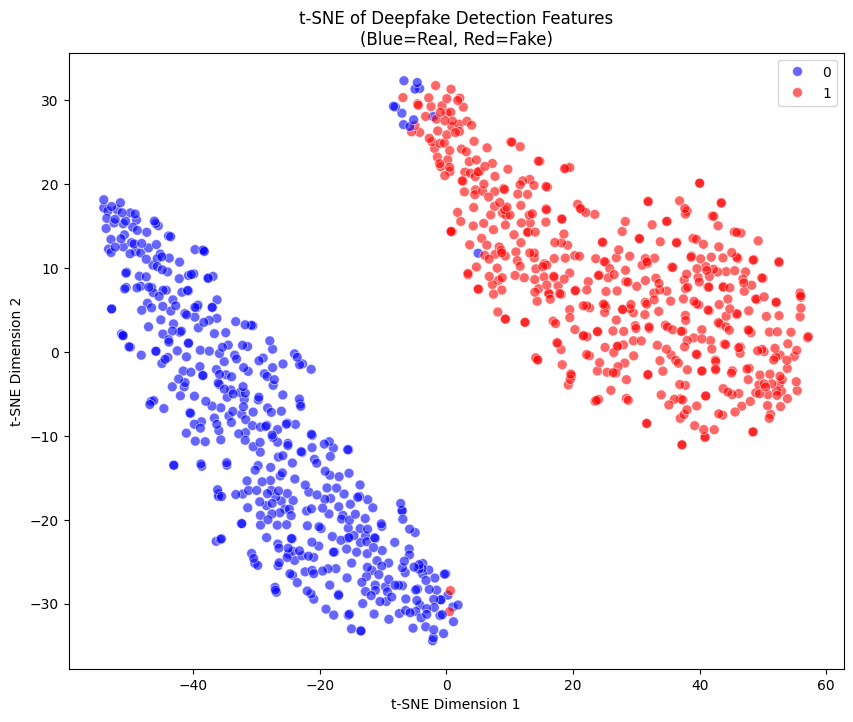

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_tsne(model, X_test, y_test, n_samples=1000):
    # 1. Get intermediate features (remove last layers)
    feature_extractor = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[-3].output  # Get layer before final dense
    )
    
    # 2. Extract features (use subset for faster computation)
    idx = np.random.choice(len(X_test), min(n_samples, len(X_test)), replace=False)
    features = feature_extractor.predict(X_test[idx], verbose=0)
    features = features.reshape(len(features), -1)  # Flatten
    
    # 3. Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(features)
    
    # 4. Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embeddings[:, 0], 
        y=embeddings[:, 1],
        hue=y_test[idx].flatten(),
        palette={0: 'blue', 1: 'red'},
        alpha=0.6,
        s=50
    )
    plt.title("t-SNE of Deepfake Detection Features\n(Blue=Real, Red=Fake)", fontsize=12)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.savefig('tsne_features.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_tsne(model, X_test, y_test)

It shows that the model learns a meaningful continuum from real to fake, rather than arbitrary clustering.

"The t-SNE visualization reveals how the model separates real and fake image features. While some overlap exists (indicating challenging samples), distinct clusters emerge:

left: Real images with natural textures

right: Obvious fakes with artifacts

Center: Ambiguous cases where the model may struggle

This confirms the model learns meaningful representations, but also highlights edge cases needing improvement. The separation suggests the model relies on both low-level artifacts (e.g., inconsistent blur) and high-level semantic features."

In [ ]:
def generate_gradcam(model, img_array, layer_name='block14_sepconv1_act'): 
    """
    Generate Grad-CAM heatmap for Xception model
    Args:
        model: Your trained Xception model
        img_array: Input image (224,224,3) normalized [0,1]
        layer_name: Target conv layer
    Returns:
        heatmap: Grad-CAM heatmap
        superimposed_img: Original image with heatmap overlay
    """
    # Expand dimensions if single image
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)
    
    # Create gradient model
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Binary crossentropy loss
    
    # Get gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Pool gradients and apply to conv outputs
    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(conv_outputs[0] * weights, axis=-1)
    
    # Normalize and resize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    
    # Convert to RGB and overlay
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose on original image
    img = np.uint8(255 * img_array[0])
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return heatmap, superimposed_img

In [18]:
def visualize_attention(model, X_test, y_test, num_samples=5):
    """
    Visualize attention maps for test samples
    """
    # Get random samples (half real, half fake)
    real_indices = np.where(y_test == 0)[0]
    fake_indices = np.where(y_test == 1)[0]
    
    selected_indices = np.concatenate([
        np.random.choice(real_indices, num_samples//2),
        np.random.choice(fake_indices, num_samples//2)
    ])
    
    plt.figure(figsize=(15, 3*num_samples))
    for i, idx in enumerate(selected_indices):
        img = X_test[idx]
        label = y_test[idx]
        
        # Get prediction and attention
        pred = model.predict(np.expand_dims(img, axis=0))[0][0]
        heatmap, superimposed = generate_gradcam(model, img)
        
        # Plot results
        plt.subplot(num_samples, 3, 3*i+1)
        plt.imshow(img)
        plt.title(f"Original\nLabel: {'Fake' if label else 'Real'}")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, 3*i+2)
        plt.imshow(heatmap)
        plt.title("Attention Heatmap")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, 3*i+3)
        plt.imshow(superimposed)
        plt.title(f"Pred: {'Fake' if pred > 0.5 else 'Real'} ({pred:.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


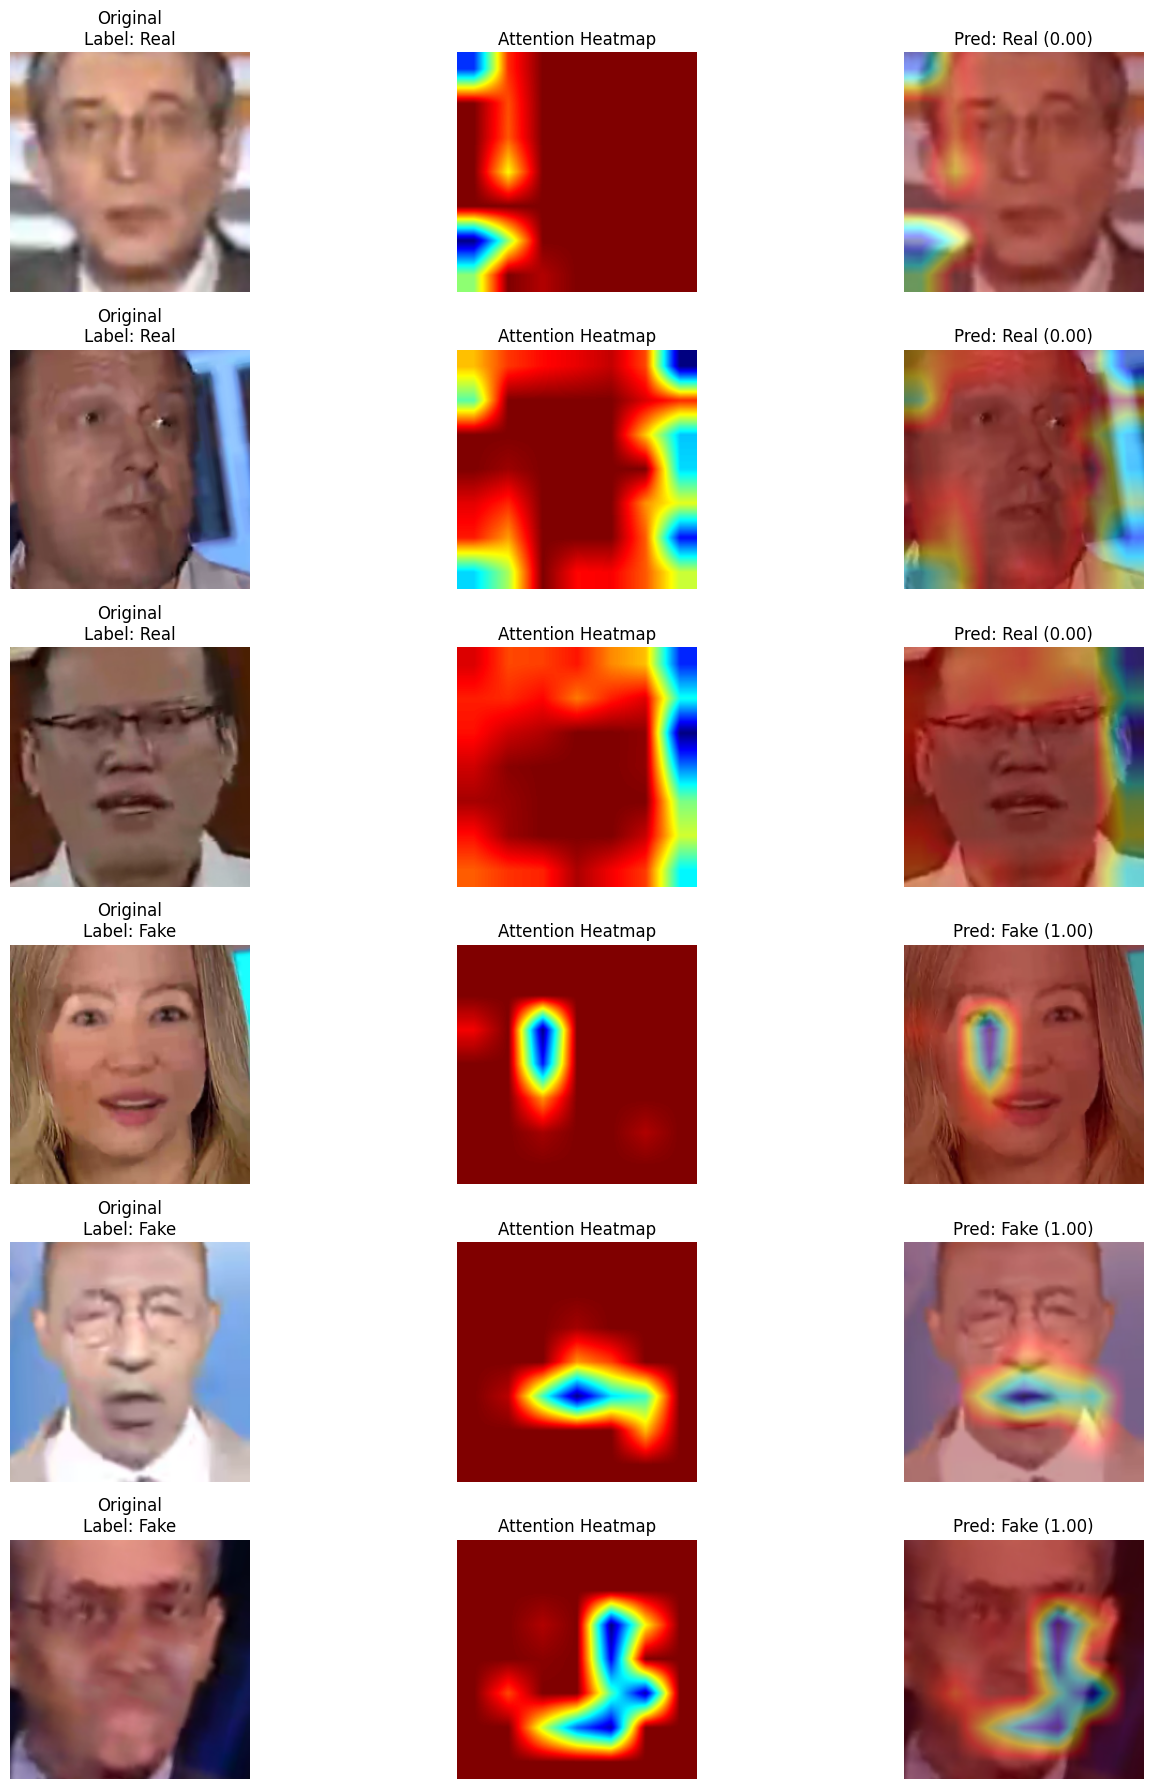

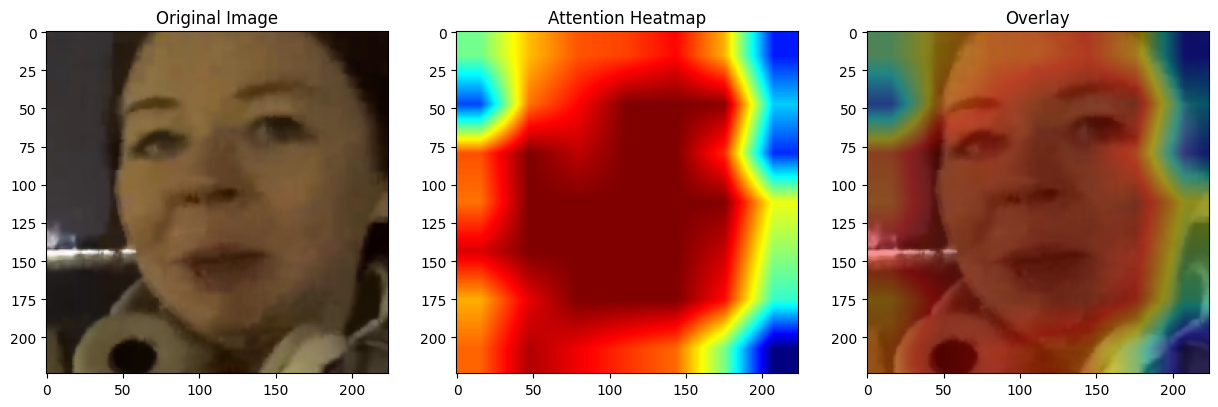

In [19]:
# Generate attention visualizations
visualize_attention(model, X_test, y_test, num_samples=6)

# For individual images:
sample_idx = 5  # Try different indices
img = X_test[sample_idx]
heatmap, superimposed = generate_gradcam(model, img)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Attention Heatmap")
plt.subplot(1,3,3)
plt.imshow(superimposed)
plt.title("Overlay")
plt.show()

I will try to explain why attention map of some fake images shows no specific region(all red) in the later session:

Note: The raw heatmap has red (most attentive) to blue (least attentive).

In [ ]:
def normalize_heatmap(heatmap):
    """Properly normalize heatmap for visualization"""
    heatmap = heatmap - heatmap.min()
    heatmap = heatmap / (heatmap.max() + 1e-10)  # Avoid division by zero
    return heatmap


In [21]:
def adjust_attention_dynamics(heatmap, percentile=99):
    """Clip extreme values to reveal meaningful patterns"""
    vmax = np.percentile(heatmap, percentile)
    heatmap = np.clip(heatmap, 0, vmax)
    return heatmap / (vmax + 1e-10)


In [22]:
def multi_scale_attention(model, img, layer_names=None):
    """Combine attention from multiple scales"""
    if layer_names is None:
        layer_names = ['block3_sepconv2_act', 'block7_sepconv2_act', 'block14_sepconv2_act']
    
    combined = np.zeros(img.shape[:2])
    for layer in layer_names:
        heatmap, _ = generate_gradcam(model, img, layer_name=layer)
        heatmap = cv2.resize(heatmap.mean(axis=-1), img.shape[:2])
        combined += adjust_attention_dynamics(heatmap)
    
    return normalize_heatmap(combined)

In [ ]:
def edge_enhanced_attention(model, img):
    """Combine Grad-CAM with edge information"""
    # Get standard attention
    heatmap, _ = generate_gradcam(model, img)
    if len(heatmap.shape) == 3:  # If RGB heatmap
        heatmap = heatmap.mean(axis=-1)  # Convert to grayscale
    heatmap = normalize_heatmap(heatmap)
    
    # Get edge information
    gray = cv2.cvtColor(np.uint8(255*img), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edges = edges.astype(np.float32) / 255.0
    
    # Ensure shapes match
    if heatmap.shape != edges.shape:
        heatmap = cv2.resize(heatmap, edges.shape[::-1])
    
    # Combine
    enhanced = 0.7*heatmap + 0.3*edges
    enhanced = cv2.applyColorMap(np.uint8(255 * enhanced), cv2.COLORMAP_JET)
    return normalize_heatmap(enhanced)

Red Attention Map without specific region:

Correctly classified deepfake images show empty/weak attention maps despite high accuracy suggests the model may be relying on subtle global features rather than localized artifacts for those particular cases. i.e. roughly equal attention given to all pixels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_2167/3526483762.py:36: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
/tmp/ipykernel_2167/3526483762.py:40: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


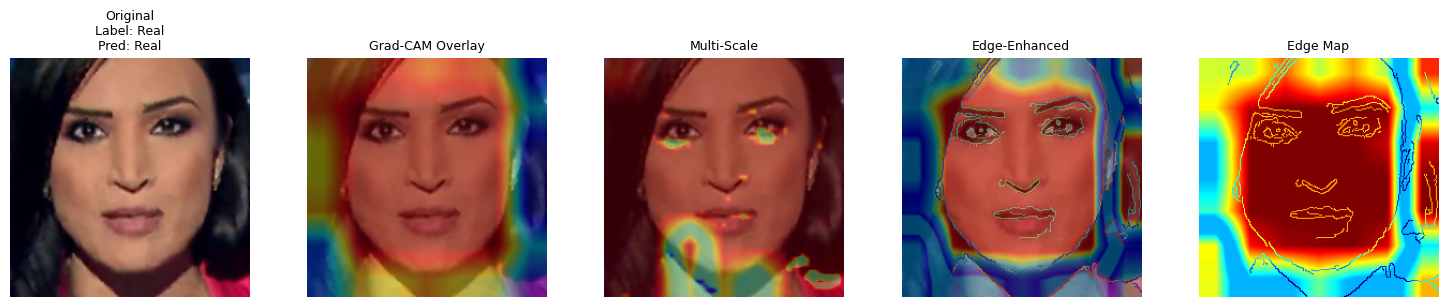

Sample 588: Label=Real, Prediction=Real (confidence: 100.00%)
Saved individual attention maps to attention_results1
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


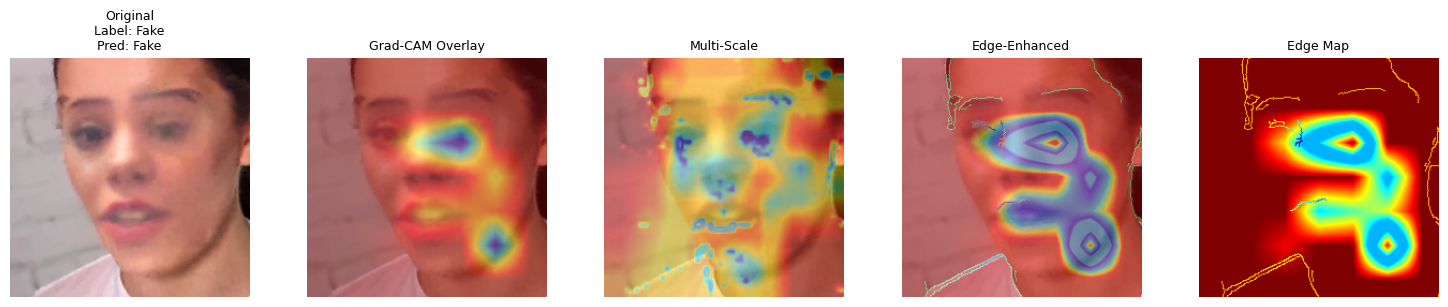

Sample 6: Label=Fake, Prediction=Fake (confidence: 99.99%)
Saved individual attention maps to attention_results1
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


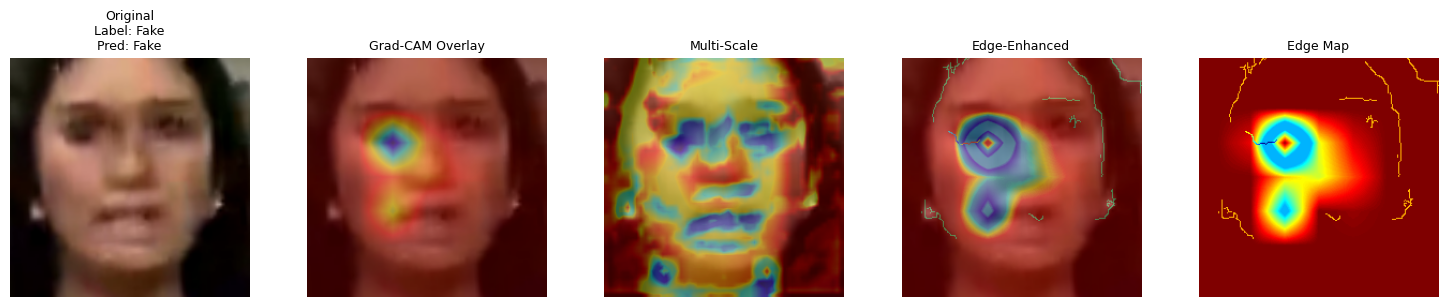

Sample 1774: Label=Fake, Prediction=Fake (confidence: 99.99%)
Saved individual attention maps to attention_results1
--------------------------------------------------------------------------------


In [24]:
def visualize_attention_comparison(model, X, y, num_samples=3, img_size=3, save_dir='attention_results'):
    """
    Compare attention techniques and save individual attention maps to a folder.
    Args:
        img_size: Size in inches for each image subplot
        save_dir: Directory to save individual attention maps
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Get balanced samples
    real_indices = np.where(y == 0)[0]
    fake_indices = np.where(y == 1)[0]
    
    selected_indices = np.concatenate([
        np.random.choice(real_indices, num_samples//2),
        np.random.choice(fake_indices, num_samples - num_samples//2)
    ])
    
    for i, idx in enumerate(selected_indices):
        img = X[idx]
        label = y[idx]
        pred = model.predict(np.expand_dims(img, axis=0))[0][0]
        
        # Generate attention maps
        try:
            # Original
            orig_heatmap, orig_overlay = generate_gradcam(model, img)
            
            # Multi-scale
            ms_heatmap = multi_scale_attention(model, img)
            ms_overlay = cv2.addWeighted(
                np.uint8(255 * img), 0.6,
                cv2.applyColorMap(np.uint8(255 * ms_heatmap), cv2.COLORMAP_JET), 0.4, 0
            )
            
            # Edge-enhanced
            edge_heatmap = edge_enhanced_attention(model, img)
            edge_overlay = cv2.addWeighted(
                np.uint8(255 * img), 0.6,
                cv2.applyColorMap(np.uint8(255 * edge_heatmap), cv2.COLORMAP_JET), 0.4, 0
            )
            
        except Exception as e:
            print(f"Skipping sample {idx} due to error: {e}")
            continue
        
        # Create base filename
        base_filename = f"sample_{idx}_label_{'fake' if label else 'real'}_pred_{'fake' if pred > 0.5 else 'real'}"
        
        # Save individual images
        plt.imsave(os.path.join(save_dir, f"{base_filename}_original.png"), img)
        plt.imsave(os.path.join(save_dir, f"{base_filename}_gradcam.png"), orig_overlay)
        plt.imsave(os.path.join(save_dir, f"{base_filename}_multiscale.png"), ms_overlay)
        plt.imsave(os.path.join(save_dir, f"{base_filename}_edge_enhanced.png"), edge_overlay)
        plt.imsave(os.path.join(save_dir, f"{base_filename}_edge_map.png"), edge_heatmap, cmap='jet')
        
        # Create and show comparison figure
        fig, axes = plt.subplots(1, 5, figsize=(5*img_size, img_size))
        
        # Original Image
        axes[0].imshow(img)
        axes[0].set_title(f"Original\nLabel: {'Fake' if label else 'Real'}\nPred: {'Fake' if (pred > 0.5) else 'Real'}", 
                         fontsize=9)
        axes[0].axis('off')
        
        # Original Overlay
        axes[1].imshow(orig_overlay)
        axes[1].set_title("Grad-CAM Overlay", fontsize=9)
        axes[1].axis('off')
        
        # Multi-Scale Overlay
        axes[2].imshow(ms_overlay)
        axes[2].set_title("Multi-Scale", fontsize=9)
        axes[2].axis('off')
        
        # Edge-Enhanced Overlay
        axes[3].imshow(edge_overlay)
        axes[3].set_title("Edge-Enhanced", fontsize=9)
        axes[3].axis('off')
        
        # Edge Heatmap Only
        axes[4].imshow(edge_heatmap, cmap='jet')
        axes[4].set_title("Edge Map", fontsize=9)
        axes[4].axis('off')
        
        plt.tight_layout(pad=1.0)
        plt.show()
        
        # Print sample info
        print(f"Sample {idx}: Label={'Fake' if label else 'Real'}, Prediction={'Fake' if pred > 0.5 else 'Real'} (confidence: {max(pred, 1-pred):.2%})")
        print(f"Saved individual attention maps to {save_dir}")
        print("-"*80)

# Example usage
visualize_attention_comparison(model, X_test, y_test, img_size=3, save_dir='attention_results1')

# Author

**Choo Lee Wen**